## import

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# GPU setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3080


## load data

In [20]:
xy = pd.read_csv('../data/df.csv')
xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   일시                1068 non-null   int64  
 1   평균기온(°C)          1068 non-null   float64
 2   합계 일사량(MJ/m2)     1068 non-null   float64
 3   평균 지면온도(°C)       1068 non-null   float64
 4   평균 30cm 지중온도(°C)  1068 non-null   float64
 5   5.0m 지중온도(°C)     1068 non-null   float64
 6   일 미세먼지 농도(㎍/㎥)    1068 non-null   float64
 7   승차                1068 non-null   int64  
 8   검색량               1068 non-null   float64
 9   당일 1차접종자 수        1068 non-null   float64
 10  1차접종 누계           1068 non-null   float64
 11  1차접종률(%)          1068 non-null   float64
 12  당일 2차접종자 수        1068 non-null   int64  
 13  2차접종 누계           1068 non-null   float64
 14  2차접종률(%)          1068 non-null   float64
 15  당일 3차접종자 수        1068 non-null   int64  
 16  3차접종 누계           1068 non-null   float64


## hyper parameter

In [21]:
seq_length = 5              # 5 일치의 데이터 입력
input_dim = len(xy.iloc[0])-1# feature 개수
hidden_dim = 5
output_dim = 1
learning_rate = 0.001
epoch = 3000
train_size = int(len(xy) * 0.8)
num_layers = 1
num_classes = 1

## Scaling

In [22]:
scaler = MinMaxScaler()
origin_scale = xy.iloc[:, [-1]].to_numpy()

# 입력변수를 MinMaxScaling 하기
xy.iloc[:,1:] = scaler.fit_transform(xy.iloc[:,1:])

In [23]:
# Training/Test ratio = 8:2
train_size = int(len(xy) * 0.8)
# Data Division
train_set = xy.iloc[:train_size,:]
test_set = xy.iloc[train_size - seq_length:,:]

## dataset function

In [24]:
def sliding_windows(time_series, seq_length, day):
    x = []
    y = []
    for i in range(len(time_series) - seq_length - day+1):
        _x = time_series.iloc[i:i+seq_length, 1:]
        _y = time_series.iloc[i+seq_length+day-1, [-1]]
        # print(_x, '->', _y)
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

## build dataset

In [25]:
trainX, trainY = sliding_windows(train_set, seq_length, 1)
testX, testY = sliding_windows(test_set, seq_length, 1)

### array -> tensor

In [26]:
trainX_tensor = torch.FloatTensor(trainX).to(device)
trainY_tensor = torch.FloatTensor(trainY).to(device)
testX_tensor = torch.FloatTensor(testX).to(device)
testY_tensor = torch.FloatTensor(testY).to(device)

# LSTM

In [27]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
            )
        
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):

        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size).to(device)

        out = self.fc(h_out)

        return out

In [28]:
lstm = LSTM(
    num_classes=num_classes,
    input_size=input_dim,
    hidden_size=hidden_dim,
    num_layers=num_layers).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

from tqdm import tqdm
# Train the model
# for i in 
for epoch in tqdm(range(epoch)):
    outputs = lstm(trainX_tensor)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
lstm.eval()

  4%|▎         | 112/3000 [00:00<00:02, 1115.75it/s]

100%|██████████| 3000/3000 [00:02<00:00, 1102.12it/s]


LSTM(
  (lstm): LSTM(22, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [29]:
# # Define LSTM model
# class LSTM(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
#         super(LSTM, self).__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.output_dim = output_dim
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)
        
#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
#         out, (hn, cn) = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

In [30]:
# # Initialize model and optimizer
# lstm = LSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
# optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

# from tqdm import tqdm
# # Train model
# for epoch in tqdm(range(epoch)):
#     # Forward pass
#     output = lstm(trainX_tensor)
#     loss = nn.MSELoss()(output, trainY_tensor)
    
#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     # # Print training progress
#     # if (epoch+1) % 10 == 0:
#     #     print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# # Evaluate model on test set
# lstm.eval()
# with torch.no_grad():
#     output = lstm(testX_tensor)
#     test_loss = nn.MSELoss()(output, testY_tensor)
#     print('Test Loss: {:.4f}'.format(test_loss.item()))


In [31]:
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(origin_scale)

inverse_x = inverse_scaler.inverse_transform(lstm(testX_tensor).cpu().detach().numpy())
inverse_y = inverse_scaler.inverse_transform(testY)

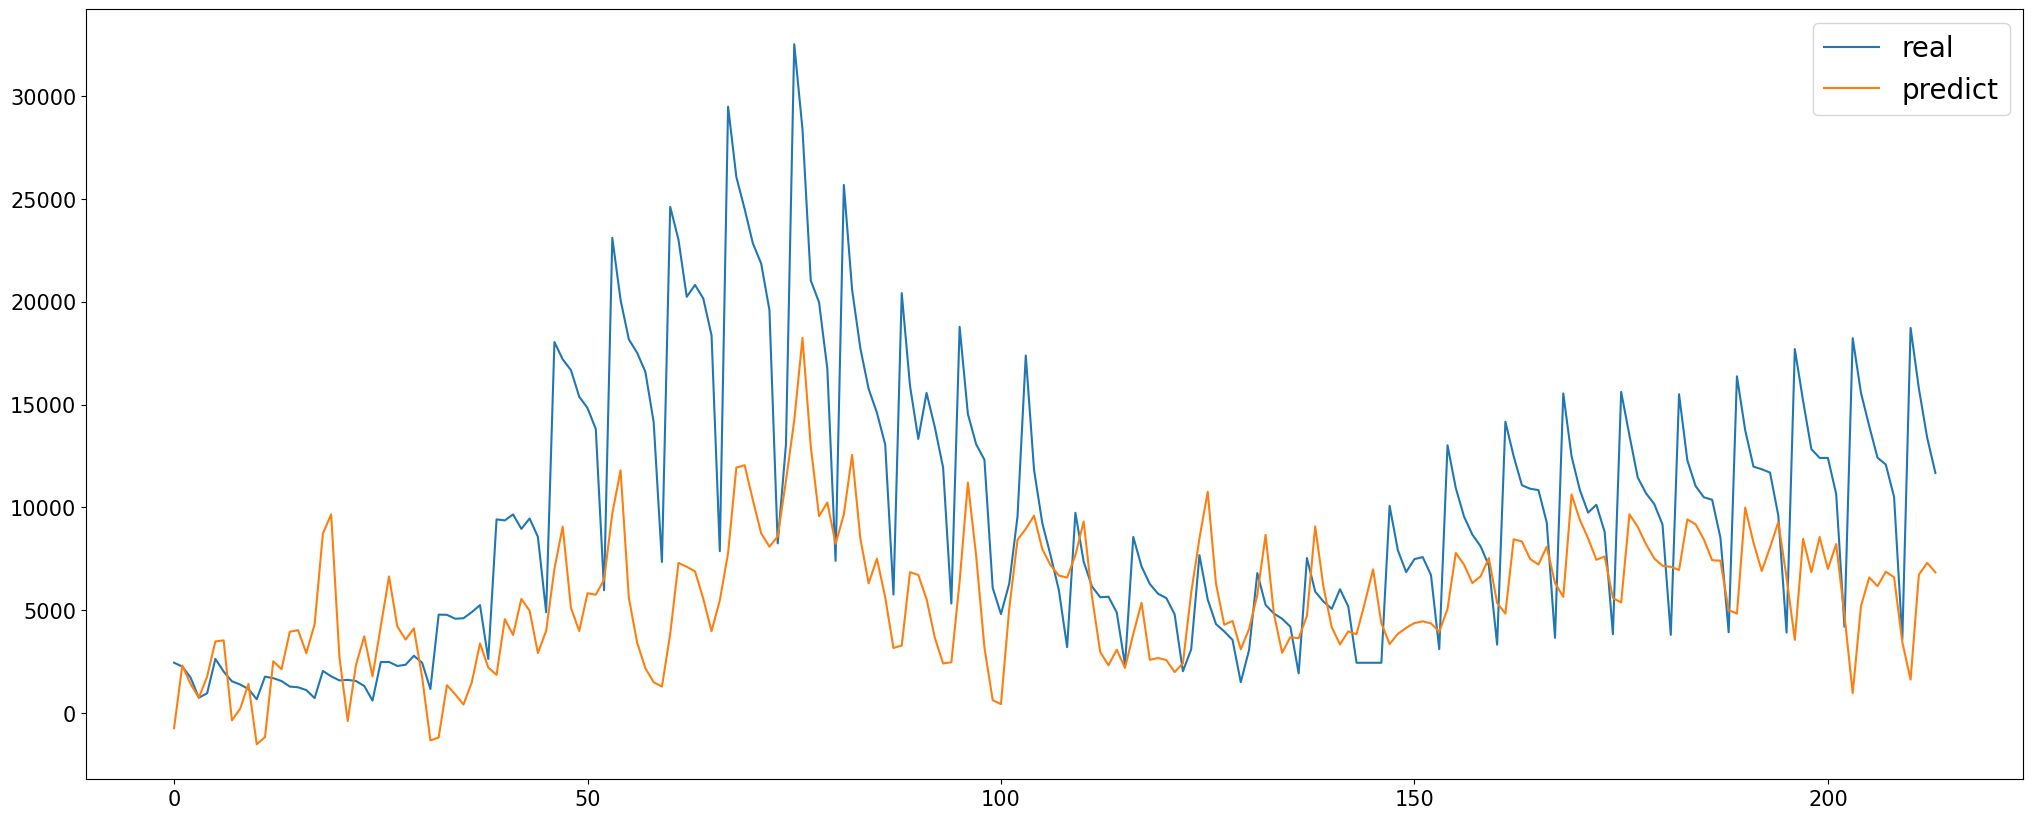

In [32]:
plt.rc('font', size=15)
plt.figure(figsize=(25,10))
plt.plot(inverse_y, label = 'real')
plt.plot(inverse_x, label = 'predict')
# plt.xlabel('테스트 셋 일자')
# plt.ylabel('확진자 수')
plt.rc('legend', fontsize = 20)
plt.legend()
plt.show()

# day 1

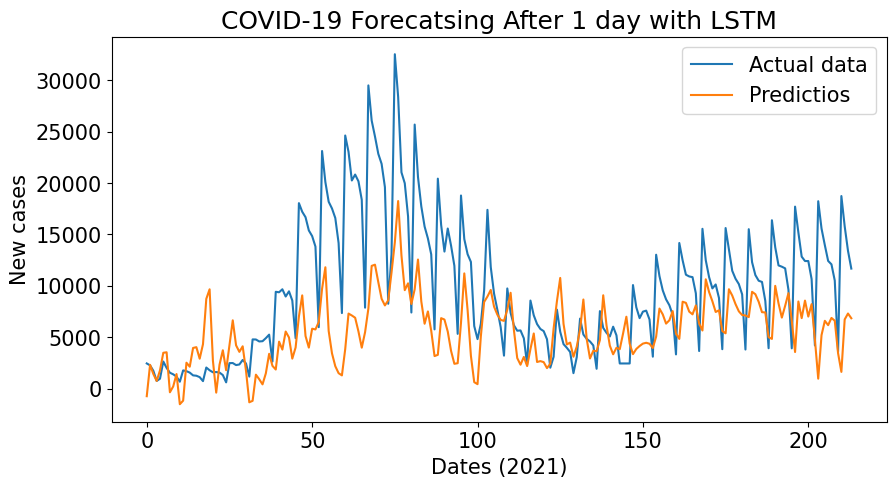

In [33]:
plt.rc('font', size=15)
plt.figure(figsize=(10,5))
plt.plot(inverse_y, label = 'Actual data')
plt.plot(inverse_x, label = 'Predictios')
plt.title('COVID-19 Forecatsing After 1 day with LSTM')
plt.xlabel('Dates (2021)')
plt.ylabel('New cases')
plt.rc('legend', fontsize = 15)
plt.legend()
plt.show()

In [34]:
def rmse(pred, real):
    E = pred-real
    SE = []
    for i in E:
        SE.append(i**2)
    MSE = sum(SE)/len(SE)
    RMSE = MSE**0.5
    return RMSE


rmse1 = rmse(inverse_x.flatten(), inverse_y.flatten())
print(rmse1)

6733.438041598985
